In [59]:
from tenpy.models.model import CouplingModel, CouplingMPOModel, MPOModel
from tenpy.algorithms.tdvp import TwoSiteTDVPEngine, SingleSiteTDVPEngine
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinHalfSite
from tenpy.linalg import np_conserved as npc
import numpy as np

from tensorflow.keras.datasets import mnist


In [60]:
import numpy as np
from qutip import *


def evolucion_rho(J_, D_, h_, rho0=None, dt=0.1, state=None, energy=False):
    N = len(D_)

    def sigma(op, i):
        return tensor([op if n == i else qeye(2) for n in range(N)])

    # Construcción del Hamiltoniano
    H = 0 * tensor([qeye(2) for _ in range(N)])

    for i in range(N):
        for j in range(i):
            if J_[i, j] != 0:
                H += J_[j, i] * sigma(sigmax(), i) * sigma(sigmax(), j)

    for i in range(N):
        H += 0.5 * (h_ + D_[i]) * sigma(sigmaz(), i)


    # Operador de evolución U = exp(-i H dt)
    U = (-1j * H * dt).expm()
    # Si se proporciona un estado puro
    if state is not None:
        if isinstance(state, np.ndarray):
            state = state.reshape(-1, 1)
            state = Qobj(state, dims=[[2]*N, [1]*N])
        state_dt = U @ state

        if energy:
            e = (state_dt.dag() * H * state_dt).full().real.item()
            return state_dt, e
        return state_dt

    # Si se proporciona una matriz de densidad
    if rho0 is not None:
        if isinstance(rho0, np.ndarray):
            rho0 = Qobj(rho0, dims=[[2]*N, [2]*N])
        rho_dt = U @ rho0 @ U.dag()
        if energy:
            e = (rho_dt * H).tr().real
            return rho_dt, e
        return rho_dt



In [61]:
import numpy as np

def z_i(n, i):
    """
    Construye el operador Z_i ⊗ I ⊗ ... ⊗ I para un sistema de n qubits.
    
    Parámetros:
    n -- número total de qubits
    i -- índice del qubit al que se aplica el operador Z (0-indexado)
    
    Devuelve:
    Una matriz numpy de dimensión (2^n, 2^n)
    """
    # Matrices básicas
    I = np.array([[1, 0], [0, 1]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)

    # Construimos la lista de operadores
    ops = []
    for j in range(n):
        if j == i:
            ops.append(Z)
        else:
            ops.append(I)

    # Producto tensorial de todos los operadores
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)

    return result


In [62]:
class CustomHamiltonian(CouplingMPOModel):
    def __init__(self, model_params):
        """Constructor del modelo."""
        self.model_params = model_params
        self.Js = model_params["Js"]
        self.W = model_params["W"]
        self.h = model_params["h"]
        self.N = model_params["L"]
        self.bc_MPS = model_params["bc_MPS"]
        self.bc_x = model_params["bc_x"]
        self.lattice = model_params["lattice"]
        self.D = np.zeros(self.N)
        self.J = np.zeros((self.N, self.N))
        super().__init__(model_params)

    
    def init_sites(self, model_params):
        """Define el tipo de sitio: espines 1/2 en este caso."""
        return SpinHalfSite(conserve=None)  # No conservamos la magnetización total

    def init_terms(self, model_params):
        """Define los términos del Hamiltoniano."""

        site = SpinHalfSite(conserve=None)
        np.random.seed(0)  # Para reproducibilidad
        D = np.random.uniform(-self.W, self.W, size=self.N) #onsite disorder
        J = np.random.uniform(-0.5*self.Js, 0.5*self.Js, size=(self.N, self.N)) #spin-spin coupling
        self.D = D
        self.J = J
        for i in range(self.N):
            self.add_onsite_term(0.5*(self.h+D[i]), i, "Sigmaz")
            for j in range(i+1, self.N):
                self.add_coupling_term(J[i,j], i, j, "Sigmax", "Sigmax")


In [137]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
## 

train_lim  = 1000
x_train = x_train[:train_lim]
y_train = y_train[:train_lim]

x_test = x_test[:500]
y_test = y_test[:500]

##
x_train_vectors = x_train.reshape(-1, 28*28, )
x_test_vectors = x_test.reshape(-1, 28*28, )

In [ ]:
np.savez('X_train_ED_1000_time_2_zone=IV.npz', y=y_train)

In [64]:
def get_state(x, n):
    """Encodes the input data into a quantum state."""


    x_ = np.zeros(2**n, dtype=x.dtype)
    x_[:len(x)] = x  # Copiar los valores de arr

    x = x_/np.linalg.norm(x_)  # Normalize the input

    
    return x

In [65]:
def amplitude_encoding(x, n):
    """Encodes the input data into a quantum state."""


    x_ = np.zeros(2**n, dtype=x.dtype)
    x_[:len(x)] = x  # Copiar los valores de arr

    x = x_/np.linalg.norm(x_)  # Normalize the input

    x = npc.Array.from_ndarray_trivial(x.reshape([2]*n), labels=[f'p{i}' for i in range(n)])
    
    mps = MPS.from_full(sites=[SpinHalfSite(conserve=None)]*n,
                        psi=x, 
                        bc='finite',
                        normalize=True)
    
    return mps

In [132]:
n=10
model_params = {"lattice": "Chain",
                "L": n,
                "bc_MPS": "finite",
                "bc_x": "periodic",
                "Js": 20,
                "W": 2000,
                "h": 20,
                "N": n
                }
hamiltonian = CustomHamiltonian(model_params)

/home/victor/TFM/simulacion/tenpy/tenpy/tools/params.py:232: UserWarning: unused options for config CustomHamiltonian:
['Js', 'N', 'W', 'h']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [67]:
X_train = []
X_train_ = []

In [104]:
tdvp_params = {
    'start_time': 0,
    'dt': 0.1,
    'max_dt':0.5,
    'N_steps': 1,
    'trunc_params': {
        'chi_max': 50,
        'svd_min': 1.e-15,
        'trunc_cut': None
    },
    'lanczos_params': {
        'N_steps': 50,     # Más vectores para explorar mejor el subespacio
        'tol': 1e-10
    },
    'max_trunc_error': 1e-10
    
}

In [135]:
for l in range(1):
    print(f'Procesando imagen {l+1}/{len(x_train_vectors)}')
    mps = amplitude_encoding(x_train_vectors[l], 10)
    z = mps.sites[0].get_op('Sigmaz')

    X_train_TN = {}
    tdvp_engine = TwoSiteTDVPEngine(mps, hamiltonian, tdvp_params)
    for k in range(1, 11):
        tdvp_engine.run()

        features = np.concatenate([
        mps.expectation_value(z),  # shape (10,)

        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+1]).item() for i in range(n-1)]),  # shape (9,)
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+2]).item() for i in range(n-2)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+3]).item() for i in range(n-3)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+4]).item() for i in range(n-4)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+5]).item() for i in range(n-5)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+6]).item() for i in range(n-6)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+7]).item() for i in range(n-7)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+8]).item() for i in range(n-8)]),
        np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+9]).item() for i in range(n-9)]),

        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2)]).item() for i in range(n-2)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3)]).item() for i in range(n-3)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3), ('Sigmaz', i+4)]).item() for i in range(n-4)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3), ('Sigmaz', i+4), ('Sigmaz', i+5)]).item() for i in range(n-5)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3), ('Sigmaz', i+4), ('Sigmaz', i+5), ('Sigmaz', i+6)]).item() for i in range(n-6)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3), ('Sigmaz', i+4), ('Sigmaz', i+5), ('Sigmaz', i+6), ('Sigmaz', i+7)]).item() for i in range(n-7)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3), ('Sigmaz', i+4), ('Sigmaz', i+5), ('Sigmaz', i+6), ('Sigmaz', i+7), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+2), ('Sigmaz', i+3), ('Sigmaz', i+4), ('Sigmaz', i+5), ('Sigmaz', i+6), ('Sigmaz', i+7), ('Sigmaz', i+8), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+4)]).item() for i in range(n-4)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+2), ('Sigmaz', i+4)]).item() for i in range(n-4)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+3), ('Sigmaz', i+4)]).item() for i in range(n-4)]),

        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+2), ('Sigmaz', i+5)]).item() for i in range(n-5)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+3), ('Sigmaz', i+5)]).item() for i in range(n-5)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+4), ('Sigmaz', i+5)]).item() for i in range(n-5)]),

        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+6)]).item() for i in range(n-6)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+2), ('Sigmaz', i+6)]).item() for i in range(n-6)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+3), ('Sigmaz', i+6)]).item() for i in range(n-6)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+4), ('Sigmaz', i+6)]).item() for i in range(n-6)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+5), ('Sigmaz', i+6)]).item() for i in range(n-6)]),

        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+7)]).item() for i in range(n-7)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+2), ('Sigmaz', i+7)]).item() for i in range(n-7)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+3), ('Sigmaz', i+7)]).item() for i in range(n-7)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+4), ('Sigmaz', i+7)]).item() for i in range(n-7)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+5), ('Sigmaz', i+7)]).item() for i in range(n-7)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+6), ('Sigmaz', i+7)]).item() for i in range(n-7)]),

        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+2), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+3), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+4), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+5), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+6), ('Sigmaz', i+8)]).item() for i in range(n-8)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+7), ('Sigmaz', i+8)]).item() for i in range(n-8)]),


        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+1), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+2), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+3), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+4), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+5), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+6), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+7), ('Sigmaz', i+9)]).item() for i in range(n-9)]),
        np.array([mps.expectation_value_term([('Sigmaz', i), ('Sigmaz', i+8), ('Sigmaz', i+9)]).item() for i in range(n-9)])

        ])
        X_train_TN[2*k] = features



Procesando imagen 1/500


/tmp/ipykernel_4566/1494671739.py:14: UserWarning: Non-string operator: can't auto-determine Jordan-Wigner!
  np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+1]).item() for i in range(n-1)]),  # shape (9,)
/tmp/ipykernel_4566/1494671739.py:15: UserWarning: Non-string operator: can't auto-determine Jordan-Wigner!
  np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+2]).item() for i in range(n-2)]),
/tmp/ipykernel_4566/1494671739.py:16: UserWarning: Non-string operator: can't auto-determine Jordan-Wigner!
  np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+3]).item() for i in range(n-3)]),
/tmp/ipykernel_4566/1494671739.py:17: UserWarning: Non-string operator: can't auto-determine Jordan-Wigner!
  np.array([mps.correlation_function(ops1=z, ops2=z, sites1=[i], sites2=[i+4]).item() for i in range(n-4)]),
/tmp/ipykernel_4566/1494671739.py:18: UserWarning: Non-string operator: can't auto-determine Jordan-Wigner!
  np.array

In [123]:
mps = amplitude_encoding(x_train_vectors[0], 10)
z = mps.sites[0].get_op('Sigmaz')
correlator_01 = []
tdvp_engine = TwoSiteTDVPEngine(mps, hamiltonian, tdvp_params)
for _ in range(20):
    tdvp_engine.run()
    correlator_01.append(mps.correlation_function(ops1=z, ops2=z, sites1=[0], sites2=[1]))

/home/victor/TFM/simulacion/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['max_trunc_error'] for config TwoSiteTDVPEngine
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/tmp/ipykernel_4566/1464002863.py:7: UserWarning: Non-string operator: can't auto-determine Jordan-Wigner!
  correlator_01.append(mps.correlation_function(ops1=z, ops2=z, sites1=[0], sites2=[1]))


In [124]:
state = get_state(x_train_vectors[0], 10)
correlator_01_d = []
for _ in range(20):
    state = evolucion_rho(hamiltonian.J, hamiltonian.D, hamiltonian.h, dt=0.1, state=state, energy=False)
    correlator_01_d.append(state.full().conj().T@z_i(n,0)@z_i(n,1)@state.full())

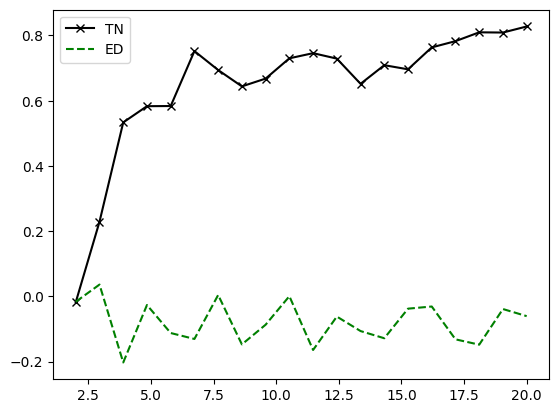

In [126]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(2,20,20), np.array(correlator_01).reshape(20,), label='TN', color='black', linestyle='solid', marker='x')
plt.plot(np.linspace(2,20,20), np.array(correlator_01_d).reshape(20,), label='ED', color='g', linestyle='--', marker='')
plt.legend()

In [ ]:
n=10
model_params = {"lattice": "Chain",
                "L": n,
                "bc_MPS": "finite",
                "bc_x": "periodic",
                "Js": 20,
                "W": 0.2,
                "h": 0.2,
                "N": n
                }
hamiltonian = CustomHamiltonian(model_params)
for l in range(1):
    print(f'Procesando imagen {l+1}/{len(x_train_vectors)}')
    state = get_state(x_train_vectors[l], 10)
    features_dic = {}
    for j in range(1, 11):
        state = evolucion_rho(hamiltonian.J, hamiltonian.D, hamiltonian.h, dt=0.1, state=state, energy=False)

        features_dic[2*j] = ([np.array(state.full().conj().T@z_i(n,i)@state.full()).reshape(1,) for i in range(n)] + 
                    
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+1)@state.full()).reshape(1,) for i in range(n-1)] + 
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+2)@state.full()).reshape(1,) for i in range(n-2)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+3)@state.full()).reshape(1,) for i in range(n-3)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+4)@state.full()).reshape(1,) for i in range(n-4)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+5)@state.full()).reshape(1,) for i in range(n-5)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +

                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@state.full()).reshape(1,) for i in range(n-2)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@state.full()).reshape(1,) for i in range(n-3)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@z_i(n,i+4)@state.full()).reshape(1,) for i in range(n-4)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@z_i(n,i+4)@z_i(n,i+5)@state.full()).reshape(1,) for i in range(n-5)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@z_i(n,i+4)@z_i(n,i+5)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@z_i(n,i+4)@z_i(n,i+5)@z_i(n,i+6)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@z_i(n,i+4)@z_i(n,i+5)@z_i(n,i+6)@z_i(n,i+7)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+2)@z_i(n,i+3)@z_i(n,i+4)@z_i(n,i+5)@z_i(n,i+6)@z_i(n,i+7)@z_i(n,i+8)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +

                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+4)@state.full()).reshape(1,) for i in range(n-4)] + 
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+2)@z_i(n,i+4)@state.full()).reshape(1,) for i in range(n-4)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+3)@z_i(n,i+4)@state.full()).reshape(1,) for i in range(n-4)] +

                    #[np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+5)@state.full()).reshape(1,) for i in range(n-5)] + 
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+2)@z_i(n,i+5)@state.full()).reshape(1,) for i in range(n-5)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+3)@z_i(n,i+5)@state.full()).reshape(1,) for i in range(n-5)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+4)@z_i(n,i+5)@state.full()).reshape(1,) for i in range(n-5)] +  

                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+2)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+3)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+4)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+5)@z_i(n,i+6)@state.full()).reshape(1,) for i in range(n-6)] +   

                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+2)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+3)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+4)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+5)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+6)@z_i(n,i+7)@state.full()).reshape(1,) for i in range(n-7)] +  

                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+2)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+3)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+4)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+5)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+6)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+7)@z_i(n,i+8)@state.full()).reshape(1,) for i in range(n-8)] +   

                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+1)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+2)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+3)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+4)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+5)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+6)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+7)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] +
                    [np.array(state.full().conj().T@z_i(n,i)@z_i(n, i+8)@z_i(n,i+9)@state.full()).reshape(1,) for i in range(n-9)] 


                    )
np.savez('first_vector_')

Procesando imagen 1/500
Procesando imagen 2/500
Procesando imagen 3/500
Procesando imagen 4/500
Procesando imagen 5/500
Procesando imagen 6/500
Procesando imagen 7/500
Procesando imagen 8/500
Procesando imagen 9/500
Procesando imagen 10/500
Procesando imagen 11/500
Procesando imagen 12/500
Procesando imagen 13/500
Procesando imagen 14/500
Procesando imagen 15/500
Procesando imagen 16/500
Procesando imagen 17/500
Procesando imagen 18/500
Procesando imagen 19/500
Procesando imagen 20/500
Procesando imagen 21/500
Procesando imagen 22/500
Procesando imagen 23/500
Procesando imagen 24/500
Procesando imagen 25/500
Procesando imagen 26/500
Procesando imagen 27/500
Procesando imagen 28/500
Procesando imagen 29/500
Procesando imagen 30/500
Procesando imagen 31/500
Procesando imagen 32/500
Procesando imagen 33/500
Procesando imagen 34/500
Procesando imagen 35/500
Procesando imagen 36/500
Procesando imagen 37/500
Procesando imagen 38/500
Procesando imagen 39/500
Procesando imagen 40/500
Procesand

In [16]:
X_test = []

In [17]:
#for i in range(len(x_test_vectors)):
#    print(f'Procesando imagen {i+1}/{len(x_test_vectors)}')
#    mps = amplitude_encoding(x_test_vectors[i], 10)
#    z = mps.sites[0].get_op('Sz')
#
#    tdvp_engine = TwoSiteTDVPEngine(mps, hamiltonian, tdvp_params)
#    tdvp_engine.run()
#
#    X_test.append(mps.expectation_value(z))

In [18]:
for i in range(len(x_test_vectors)):
    print(f'Procesando imagen {i+1}/{len(x_test_vectors)}')
    state = evolucion_rho(hamiltonian.J, hamiltonian.D, hamiltonian.h, dt=20, state=get_state(x_test_vectors[i], 10), energy=False)

    X_test.append([np.array(state.full().conj().T@z_i(n,i)@state.full()).reshape(1,) for i in range(n)] + [np.array(state.full().conj().T@z_i(n,i)@z_i(n,i+1)@state.full()).reshape(1,) for i in range(n-1)])

Procesando imagen 1/1000
Procesando imagen 2/1000
Procesando imagen 3/1000
Procesando imagen 4/1000
Procesando imagen 5/1000
Procesando imagen 6/1000
Procesando imagen 7/1000
Procesando imagen 8/1000
Procesando imagen 9/1000
Procesando imagen 10/1000
Procesando imagen 11/1000
Procesando imagen 12/1000
Procesando imagen 13/1000
Procesando imagen 14/1000
Procesando imagen 15/1000
Procesando imagen 16/1000
Procesando imagen 17/1000
Procesando imagen 18/1000
Procesando imagen 19/1000
Procesando imagen 20/1000
Procesando imagen 21/1000
Procesando imagen 22/1000
Procesando imagen 23/1000
Procesando imagen 24/1000
Procesando imagen 25/1000
Procesando imagen 26/1000
Procesando imagen 27/1000
Procesando imagen 28/1000
Procesando imagen 29/1000
Procesando imagen 30/1000
Procesando imagen 31/1000
Procesando imagen 32/1000
Procesando imagen 33/1000
Procesando imagen 34/1000
Procesando imagen 35/1000
Procesando imagen 36/1000
Procesando imagen 37/1000
Procesando imagen 38/1000
Procesando imagen 39/

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
accuracy = []
scaler = StandardScaler()
X_train = scaler.fit_transform(np.real(np.array(X_train_flat)))
X_test = scaler.transform(np.real(np.array(X_test_flat)))
for i in np.linspace(1000, 15000, 5):
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
    clf.fit(X_train[:int(i)], y_train[:int(i)])

    y_class = clf.predict(X_test[:5000])
    accuracy.append(np.sum(y_class == y_test[:5000]) / len(y_test[:5000]))

/home/victor/TFM/simulacion/tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/victor/TFM/simulacion/tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/victor/TFM/simulacion/tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/victor/TFM/simulacion/tp/lib/python3.12/site-packages/sklearn/linear_model/_log

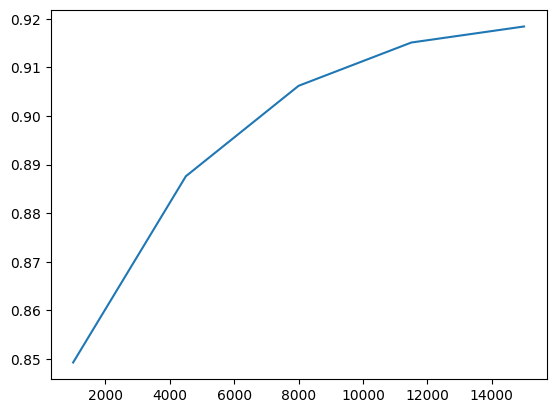

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(1000, 15000, 5), accuracy)